In this example we build a simple neural network in tensorflow to classify handwritten digits from the well-known mnist dataset. Mnist stands for Modified National Institute of Standards and Technology, and the dataset is a widely used, easy to learn, set of handwritten digits. The best models can get an error rate of < 0.5%.

First download the mnist data. The data source we use is: https://pjreddie.com/projects/mnist-in-csv/

In [162]:
import os
import urllib
if 'mnist_train.csv' not in os.listdir("."):
    url = 'https://pjreddie.com/media/files/mnist_train.csv'
    urllib.urlretrieve(url, 'mnist_train.csv')
if 'mnist_test.csv' not in os.listdir("."):
    url = 'https://pjreddie.com/media/files/mnist_test.csv'
    urllib.urlretrieve(url, 'mnist_test.csv')

Now that we have the files, read them into an array. Each file contains one line for each image, with comma separated values. On each line the first number is the digit to predict (0 up to 9) and the remaining 784 numbers are the pixel values (in the range 0 to 255).

In [163]:
def read_mnist_data(filename):
    # Open the file for reading
    f = open(filename, 'r')
    
    # X is a list of all the images, represented as 784 pixels (for a 28x28 image)
    X = []
    # Y is a list of the corresponding labels (0-9)
    Y = []
    
    # For each line in the file, add the image to X and add the label to Y
    for line in f:
        # First map the line (which is just a string) to an array containing the numbers in the line
        values = map(int, line.split(','))
        # The label is the first value
        Y.append(values[0])
        # The image is the list of remaining values
        X.append(values[1:])
    X = np.array(X, "float") / 255.0
    return X, Y

In [164]:
X_train_all, Y_train_all = read_mnist_data('mnist_train.csv')
X_test, Y_test = read_mnist_data('mnist_test.csv')

In [165]:
import numpy as np
print np.shape(X_train_all)

(60000, 784)


Let's have a look at a few images so that we understand the data we are trying to learn. Note that each image is grayscale.

In [166]:
import matplotlib.pyplot as plt
# Takes in an array of 784 pixel values and a label for the title of the image
def plot_image(pixels, label):
    image = np.reshape(pixels, [28,28])
    plt.imshow(image, cmap='gray')
    plt.title(label)
    plt.show()

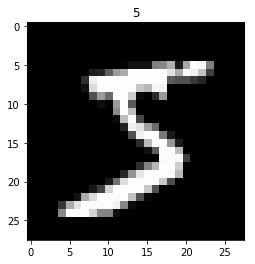

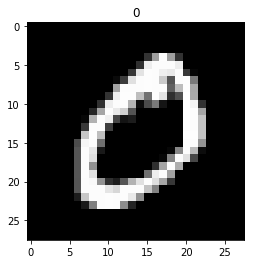

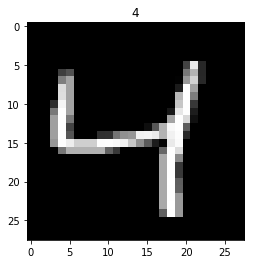

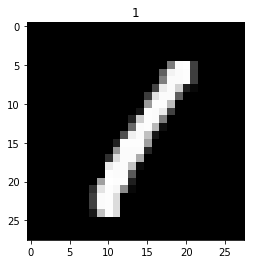

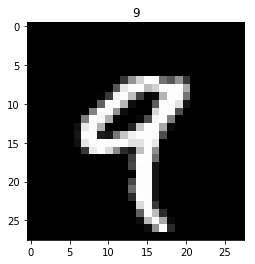

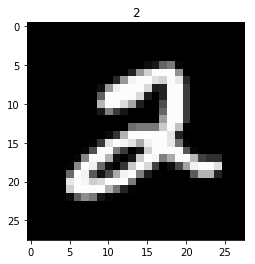

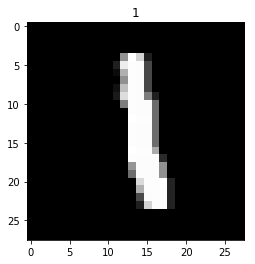

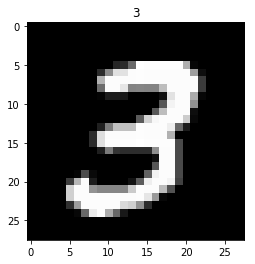

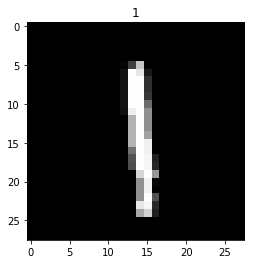

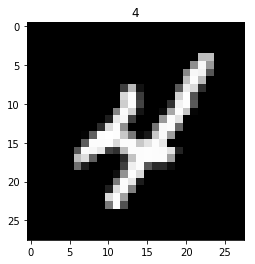

In [167]:
for i in range(10):
    plot_image(X_train_all[i], Y_train_all[i])

We split the training data into training and validation data so that we can avoid overfitting. We use 20% of the data for validation and the remaining 80% for training.

In [168]:
train_pc = 0.8
num_train = int(len(X_train_all) * train_pc)
X_train = X_train_all[:num_train]
Y_train = Y_train_all[:num_train]
X_valid = X_train_all[num_train:]
Y_valid = Y_train_all[num_train:]
print "Using", len(X_train), "images for training and", len(X_valid), "images for validation."

Using 48000 images for training and 12000 images for validation.


We now use tensorflow to create a simple neural network and try to use this to classify the mnist data.

In [169]:
import tensorflow as tf

def build_network(num_hidden, num_input=784, num_output=10):
    # The input layer takes in an array with 784 columns and any number of rows.
    # This lets us pass in the data in batches.
    input_layer = tf.placeholder("float", shape=[None, num_input])
    
    # The first layer is just input_layer * W1 + b1, where W1 is a 784 x num_hidden
    # matrix and b1 is a num_hidden-dimensional vector. We then apply a nonlinearity,
    # and have chosen to use relu here. The relu function just sets all negative entries
    # to zero. It's important to put something nonlinear in, else using 2 layers
    # would have the same effect as using 1 layer.
    W1 = tf.Variable(tf.truncated_normal([num_input, num_hidden], stddev=0.01))
    b1 = tf.Variable(tf.constant(0.1, shape=[num_hidden]))
    fc1 = tf.nn.relu(tf.matmul(input_layer, W1) + b1)
    
    # Note that fc1 will be a batch_size x num_hidden array.
    
    # The second layer is defined in exactly the same way as the first, but we don't
    # apply a relu afterwards. The output of fc2 will be a batch_size x 10 array.
    W2 = tf.Variable(tf.truncated_normal([num_hidden, num_output], stddev=0.01))
    b2 = tf.Variable(tf.constant(0.1, shape=[num_output]))
    fc2 = tf.matmul(fc1, W2) + b2
    
    # Now use a sigmoid to make the entries in each row sum to 1. We can interpret the
    # output as the probability that the digit is that value.
    output_layer = tf.nn.softmax(fc2)
    
    # We only need to have access to the input layer and output layer -- tensorflow
    # will do the rest!
    return input_layer, output_layer

Now build a network with 100 hidden units, using the function above, and define some operators in tensorflow to do the training for us.

In [170]:
tf_input_layer, tf_output_layer = build_network(100)

# The target is a list of 'one-hot vectors'. Each vector has a 1 in the index of the
# correct label and 0s in all other places.
tf_target = tf.placeholder("float", shape=[None, 10])

The cross entropy loss for a given image is defined as -log(y_i), where y = [y_0, ..., y_9] is the output of the network for the image, and i is the correct label. Note that 0 < y_i < 1. We want y_i (our prediction on the correct class) to be close to 1, and -log(y_i) gets very small as y_i gets close to 1, while it gets very large as y_i gets close to 0. So the cross entropy loss just penalises incorrect predictions. To define it in tensorflow, note that our target vector is [0, ..., 1, ..., 0], with a 1 in the ith position, and so we can just take the dot product of our output with this target vector. We then just take the mean over all the training images. Note that 'reduce_mean' just means compute the mean of an array, rather than actually try to minimise it, and similarly 'reduce_sum' means compute the sum of the array. We reduce the sum over the index '1', so that we sum across the columns.

In [171]:
tf_output_clipped = tf.maximum(tf_output_layer, 0.0001)
tf_output_clipped = tf.minimum(tf_output_clipped, 0.9999)
tf_cross_entropy_loss = tf.reduce_mean(-tf.reduce_sum(tf_target * tf.log(tf_output_clipped), reduction_indices=[1]))

We just want to find parameters (W1, b1, W2, b2) that minimise the cross entropy loss.
Luckily for us, tensorflow can do this in just a few lines!

In [172]:
tf_train_op = tf.train.AdamOptimizer().minimize(tf_cross_entropy_loss)

So far, we have just defined the operations needed to do the training. That is, we have set up the structure, but not asked tensorflow to do anything yet. So we now need to feed the train operation with data.

In [173]:
def map_to_one_hot(Y, num_classes=10):
    one_hots = np.zeros((len(Y), num_classes))
    for i in range(len(Y)):
        one_hots[i][Y[i]] = 1.0
    return one_hots

In [174]:
def accuracy(output, targets):
    predictions = np.argmax(output, axis=1)
    return np.mean(predictions==targets)

In [176]:
tf_sess = tf.Session()
tf_sess.run(tf.global_variables_initializer())

# Map the training labels to one hot vectors for testing.
Y_train_one_hot = map_to_one_hot(Y_train)

batch_size = 100
num_epochs = 10
for epoch in range(num_epochs):
    i = 0
    while i + batch_size <= len(X_train):
        X_batch = X_train[i:i+batch_size,:]
        Y_batch = Y_train_one_hot[i:i+batch_size,:]
        _, loss, output = tf_sess.run([tf_train_op, tf_cross_entropy_loss, tf_output_layer], feed_dict={
            tf_input_layer: X_batch,
            tf_target: Y_batch
        })
        i += batch_size
    print "Epoch:", epoch, "Loss:", loss
    print "Training accuracy:", accuracy(output, np.argmax(Y_batch, axis=1))
    output_valid = tf_sess.run(tf_output_layer, feed_dict={
        tf_input_layer: X_valid
    })
    print "Validation accuracy:", accuracy(output_valid, Y_valid)

Epoch: 0 Loss: 0.489217
Training accuracy: 0.86
Validation accuracy: 0.926
Epoch: 1 Loss: 0.35094
Training accuracy: 0.86
Validation accuracy: 0.944416666667
Epoch: 2 Loss: 0.232992
Training accuracy: 0.93
Validation accuracy: 0.953
Epoch: 3 Loss: 0.160256
Training accuracy: 0.94
Validation accuracy: 0.958416666667
Epoch: 4 Loss: 0.117092
Training accuracy: 0.97
Validation accuracy: 0.961666666667
Epoch: 5 Loss: 0.0880025
Training accuracy: 0.99
Validation accuracy: 0.96575
Epoch: 6 Loss: 0.0673195
Training accuracy: 0.99
Validation accuracy: 0.967416666667
Epoch: 7 Loss: 0.0531302
Training accuracy: 0.99
Validation accuracy: 0.969583333333
Epoch: 8 Loss: 0.0425748
Training accuracy: 0.99
Validation accuracy: 0.970916666667
Epoch: 9 Loss: 0.0381979
Training accuracy: 0.99
Validation accuracy: 0.9715


Finally, we can check the test accuracy.

In [177]:
output_test = tf_sess.run(tf_output_layer, feed_dict={
    tf_input_layer: X_test
})
print accuracy(output_test, Y_test)

0.9721


Note how simple this model was: a feed-forward neural network with 100 hidden units in the middle layer. We didn't do any regularisation to prevent overfitting, and we still got > 97% accuracy on the test set (at least in the run I did most recently).